<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/where_modeling/CA_KNN_DemographicSupetSetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab is for KNN similarity 
* to find the counties from Oregon, that are similar to CA widespread counties


# Mount drive

In [17]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [18]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
#drive.flush_and_unmount(600000)

In [ ]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 All_CovidDataFeb20.csv
 alldatasets_Feb20.csv
 All_GoogleMobilityDataFeb20.csv
 All_SocialDistancingDataFeb20.csv
 AllStates_Superset_dataset_Feb20.csv
 AllStates_Superset_dataset_Feb21.csv
 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_SuperData_Labeled_CDCGuideline_Feb13.csv
 CA_SuperData_Labeled_Guideline_Feb26.csv
 CA_Superset_bins_dataset_Feb20.csv
 CA_Superset_dataset_Feb12

# Import package

In [107]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load Oregon Superset Data from All states csv

In [20]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
all_states_data = pd.read_csv(location+'AllStates_Superset_dataset_Feb21.csv', low_memory=False)
all_states_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-03,Montana,30001,0,Beaverhead County,0.0,1.139,86,9.0,7.0,0.0,0.0,-2.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,17,20,3.33,20.4,6.6,34.1,0.68,2.65,0,9404,13.2,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.0,39,46.6,0.0,0.0,0.0,0,0,0.0,0,0.7,3.5,6.6,0.3,0.0,0.0,NaN
1,2020-03-04,Montana,30001,0,Beaverhead County,0.0,1.480,113,14.0,7.0,0.0,0.0,3.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,13,16,3.44,21.3,8.4,36.1,0.71,2.73,0,9404,16.7,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.0,40,46.6,0.0,0.0,0.0,0,0,0.0,0,0.7,3.5,6.6,0.3,0.0,0.0,NaN


In [21]:
OR_superset_data = all_states_data[all_states_data['State'] == 'OR']
OR_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
45007,2020-03-01,Oregon,41031,0,Jefferson County,0.0,7.866,79,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,OR,41031,Jefferson County,41,27,23,3.33,32.4,2.0,42.2,0.3,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,39.919097
45008,2020-03-01,Oregon,41031,0,Jefferson County,0.0,5.389,69,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,OR,41031,Jefferson County,41,27,23,3.33,32.4,2.0,42.2,0.3,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,33.265914


In [22]:
OR_superset_data['positivity_rate'] = (OR_superset_data['New.cases.1000.people'] / OR_superset_data['Tests.done.1000.people'])* 100/1000
OR_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
45007,2020-03-01,Oregon,41031,0,Jefferson County,0.0,7.866,79,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,OR,41031,Jefferson County,41,27,23,3.33,32.4,2.0,42.2,0.3,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,39.919097,NaN
45008,2020-03-01,Oregon,41031,0,Jefferson County,0.0,5.389,69,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,OR,41031,Jefferson County,41,27,23,3.33,32.4,2.0,42.2,0.3,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,33.265914,NaN


In [23]:
print(OR_superset_data['County Name'].nunique())
OR_superset_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

#  Load CA Superset Labeled Data

In [24]:
ca_labeled_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_SuperData_Labeled_Guideline_Feb26.csv',low_memory=False)
ca_labeled_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
0,2020-03-01,California,6001,0,Alameda County,0.0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,860.757075,California,CA,6001,Alameda County,6,37,26,2.93,25.4,0.4,36.8,0.25,2.68,0,1666753,-5.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0000,0.0,37,54.0,0.0,0.00,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.00,0.000000,0.000,0.0,0.0,minimal
1,2020-03-02,California,6001,0,Alameda County,0.0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,860.757075,California,CA,6001,Alameda County,6,17,20,3.38,28.2,0.4,38.1,0.63,2.74,0,1666753,-2.9,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0000,0.0,38,54.0,0.0,0.00,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.00,0.000000,0.000,0.0,0.0,minimal
2,2020-03-03,California,6001,1,Alameda County,0.0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,860.757075,California,CA,6001,Alameda County,6,16,18,3.61,27.1,0.3,32.7,0.67,2.94,1,1666753,4.1,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,0.0,0.00,0.0,0,1,0.05,42,1.1,5.3,5.7,0.6,0.00,0.059997,0.000,0.0,0.0,minimal
3,2020-03-04,California,6001,0,Alameda County,0.0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,860.757075,California,CA,6001,Alameda County,6,14,18,3.55,27.9,0.3,36.9,0.68,2.87,0,1666753,1.7,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,10.3,0.01,0.0,0,1,0.06,42,1.1,5.3,5.7,0.6,0.04,0.000000,0.002,0.0,0.0,minimal
4,2020-03-05,California,6001,0,Alameda County,0.0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,860.757075,California,CA,6001,Alameda County,6,15,19,3.54,28.1,0.3,36.8,0.66,2.88,0,1666753,2.0,15.04,19,92574,10.5,22.5,49.11,1155,131,2.05,0.22,0.0,0.0002,0.0,0,54.0,10.3,0.01,0.0,0,1,0.06,42,1.1,5.3,5.7,0.6,0.04,0.000000,0.002,0.0,0.0,minimal


In [25]:
ca_labeled_superset_data['State'].unique()

array(['CA'], dtype=object)

In [26]:
ca_labeled_superset_data.shape

(15391, 63)

In [27]:
ca_labeled_superset_data.growth_label.unique()

array(['minimal', 'nochange', 'widespread'], dtype=object)

In [29]:
print("CA data - date range :", (ca_labeled_superset_data.Date.min(),ca_labeled_superset_data.Date.max()))
print("Oregon data - date ranges :", (OR_superset_data.Date.min(),OR_superset_data.Date.max()))

CA data - date range : ('2020-03-01', '2020-12-28')
Oregon data - date ranges : ('2020-03-01', '2020-12-28')



# Note (selected columns )

'Province_State', 'FIPS', 'County Name','PopDensity', 'State_Name','State', 'CTFIPS', 'CTNAME', 'STFIPS',
'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density','Testing.capacity', 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people',

**Summary**: The latent features (loc2vec features ) describe the probalistic causal behaviour of the pandemic. The features are responsible for describing the sudden increase or surge of the pandemic. The counties with closest 

* Surge in LA -> Surge in WA county in OR


# Filter columns with Demographic features

In [30]:
demographic_cols = [ 'FIPS', 'County Name', 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people']

In [31]:
or_superset_data_filtered = OR_superset_data[demographic_cols]
ca_superset_data_filtered = ca_labeled_superset_data[demographic_cols]

# Data Analysis

In [32]:
or_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,56916.0,41039.321702,19.085670,41001.000000,41029.000000,41041.000000,41053.000000,41071.000000
PopDensity,56916.0,71.920858,112.991825,0.372079,5.013675,23.112911,51.340628,715.275377
X..people.older.than.60,56916.0,26.683059,6.197261,18.000000,21.000000,26.000000,33.000000,43.000000
Median.income,56916.0,54810.040709,11036.246155,36627.000000,46396.000000,50851.000000,58655.000000,78010.000000
X..African.Americans,56916.0,0.886701,0.594938,0.100000,0.400000,0.700000,1.000000,5.300000
X..Hispanic.Americans,56916.0,13.046461,7.177246,3.600000,7.300000,12.500000,16.500000,35.900000
X..Male,56916.0,49.832760,1.319290,48.140000,48.750000,49.420000,50.390000,54.490000
Employment.density,56916.0,80.679159,142.391958,1.000000,6.000000,21.000000,53.000000,1180.000000
Testing.capacity,56916.0,4.715899,1.182308,0.000000,4.100000,4.800000,5.100000,12.300000
Ventilator.shortage,56916.0,24.408901,17.429010,0.000000,15.000000,20.000000,28.000000,82.000000


In [34]:
ca_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,15391.0,6058.123124,33.037940,6001.000000,6029.000000,6059.000000,6085.000000,6115.000000
PopDensity,15391.0,300.363532,998.803460,0.685856,16.659991,46.119104,177.727919,7168.190471
X..people.older.than.60,15391.0,22.703008,6.106907,14.000000,18.000000,21.000000,26.000000,38.000000
Median.income,15391.0,65785.613865,18730.894709,42475.000000,51261.000000,61145.000000,77609.000000,116178.000000
X..African.Americans,15391.0,3.163232,2.940425,0.300000,1.300000,2.000000,4.500000,13.600000
X..Hispanic.Americans,15391.0,32.066370,17.652660,8.700000,16.000000,26.500000,45.600000,83.800000
X..Male,15391.0,50.421286,2.449918,48.180000,49.470000,49.840000,50.730000,66.290000
Employment.density,15391.0,233.321227,514.888304,2.000000,17.000000,35.000000,148.000000,3076.000000
Testing.capacity,15391.0,7.158755,4.046564,0.000000,5.300000,5.900000,6.600000,30.300000
Ventilator.shortage,15391.0,632.983887,476.093329,0.000000,361.000000,602.000000,686.000000,2902.000000


# KNN Similarity - Util method



In [121]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        # if i == 31:
        #   print(vectors[j].reshape(1,-1))
        #   print(predicted_vectors[i].reshape(1,-1))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)
        #if cosine_sim_val > 0.5: # update threshold
          #continue
      #if i > 50: break
        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return cosine_similarities,simiarity_ids


# Data visualization county level

In [37]:
or_counties = or_superset_data_filtered['County Name'].unique()
ca_counties = ca_superset_data_filtered['County Name'].unique()
print(' # of OR counties : ',len(or_counties))
print(' # of CA counties : ',len(ca_counties))

 # of OR counties :  32
 # of CA counties :  54


**Quick note:** We would like to reduce the county data to single vector. Hence we are checking whether any column exceeds std.dev of more than 50. this 50 is adjusted as per the column category . for instance, median income can be tolerated to even 1000.0 value

In [122]:
demographic_numeric_cols = [ 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people']

In [58]:
THRESHOLD = 10.0

## Checking OR counties

In [60]:
for or_county in or_counties:
  #print("######.  ",or_county," .######")
  county_data = or_superset_data_filtered[or_superset_data_filtered['County Name'] == or_county]
  for col in demographic_numeric_cols:
    std_dev = np.std(county_data[col].values)
    if std_dev > THRESHOLD:
      print(or_county,'| column name :',col,' | value: ',np.std(county_data[col].values)) 

print("** NOTE: prints nothing indicates no column has HUGE standard deviation") 

Jefferson County | column name : Ventilator.shortage  | value:  17.27444280012827
Lake County | column name : Ventilator.shortage  | value:  17.03045263982593
Lincoln County | column name : Ventilator.shortage  | value:  17.51513667279081
Benton County | column name : Ventilator.shortage  | value:  17.51513667279081
Jackson County | column name : Ventilator.shortage  | value:  17.511284772493283
Marion County | column name : Ventilator.shortage  | value:  17.531150421734488
Polk County | column name : Ventilator.shortage  | value:  17.51513667279081
Union County | column name : Ventilator.shortage  | value:  17.26050203057189
Washington County | column name : Ventilator.shortage  | value:  17.515454789012175
Douglas County | column name : Ventilator.shortage  | value:  17.51513667279081
Grant County | column name : Ventilator.shortage  | value:  16.604228441718455
Columbia County | column name : Ventilator.shortage  | value:  17.688013243696115
Linn County | column name : Ventilator.sh

## Checking CA counties

In [61]:
for ca_county in ca_counties:
  #print("######.  ",or_county," .######")
  ca_county_data = ca_superset_data_filtered[ca_superset_data_filtered['County Name'] == ca_county]
  for col in demographic_numeric_cols:
    std_dev = np.std(ca_county_data[col].values)
    if std_dev > THRESHOLD:
      print(ca_county,'| column name :',col,' | value: ',np.std(ca_county_data[col].values)) 

print("**NOTE: prints nothing indicates no column has HUGE standard deviation") 

Alameda County | column name : Ventilator.shortage  | value:  473.2585214319907
Amador County | column name : Ventilator.shortage  | value:  485.0215558461579
Butte County | column name : Ventilator.shortage  | value:  473.2585214319907
Calaveras County | column name : Ventilator.shortage  | value:  478.83801160127507
Colusa County | column name : Ventilator.shortage  | value:  485.0215558461579
Contra Costa County | column name : Ventilator.shortage  | value:  473.2585214319907
Del Norte County | column name : Ventilator.shortage  | value:  485.0215558461579
El Dorado County | column name : Ventilator.shortage  | value:  473.2585214319907
Fresno County | column name : Ventilator.shortage  | value:  473.2585214319907
Glenn County | column name : Ventilator.shortage  | value:  485.0215558461579
Humboldt County | column name : Ventilator.shortage  | value:  473.2585214319907
Imperial County | column name : Ventilator.shortage  | value:  473.2585214319907
Inyo County | column name : Venti

## Observation: 

By checking across all the columns in Oregan and California data. We have noticed Ventilator shortage column has a significant difference. 

For CA the std.dev is around 470.0 +
Whereas, OR has std.dev of only 17.0+

So to avoid discrepancies , we are dropping Ventilator.shortage column from further analysis on reducing data

## Filtered Demographic column after **data analysis**

In [62]:
demographic_filtered_cols = [ 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people']

## Reduce each county by mean

#### Applying for Oregan

In [144]:
or_demographic_df = pd.DataFrame(columns=[ 'FIPS','County Name','PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people'],index=None)


In [68]:
or_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [145]:
for or_county in tqdm(or_counties):
  county_data = or_superset_data_filtered[or_superset_data_filtered['County Name'] == or_county]
  #print(county_data.FIPS.unique().tolist()[0])
  #print(county_data.mean(axis=1))
  reduced_df = county_data[['PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Unemployment.rate',
       'Unemployment.claims.1000.people']].apply(lambda x : x.mean()) 
  
  reduced_df['County Name'] = or_county
  reduced_df['FIPS'] = county_data.FIPS.unique().tolist()[0]
  or_demographic_df = or_demographic_df.append(reduced_df, ignore_index=True)
  #print(reduced_df.head()) 



100%|██████████| 32/32 [00:00<00:00, 74.51it/s]


In [105]:
or_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people
0,41031,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.711985,9.210112,4.058052


#### Applying for California

In [114]:
ca_demographic_df = pd.DataFrame(columns=[ 'FIPS','County Name','PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people'])


In [115]:
for ca_county in tqdm(ca_counties):
  county_data = ca_superset_data_filtered[ca_superset_data_filtered['County Name'] == ca_county]
  #print(county_data.FIPS.unique().tolist()[0])
  #print(county_data.mean(axis=1))
  reduced_df = county_data[['PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Unemployment.rate',
       'Unemployment.claims.1000.people']].apply(lambda x : x.mean()) 
  
  reduced_df['County Name'] = ca_county
  reduced_df['FIPS'] = county_data.FIPS.unique().tolist()[0]
  ca_demographic_df = ca_demographic_df.append(reduced_df, ignore_index=True)
  #print(reduced_df.head()) 



100%|██████████| 54/54 [00:00<00:00, 86.43it/s]


In [116]:
ca_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people
0,6001,Alameda County,860.757075,19.0,92574.0,10.5,22.5,49.11,1155.0,7.159589,11.916781,6.569521
1,6005,Amador County,24.565345,35.0,61198.0,2.0,13.6,53.67,20.0,7.249813,11.977903,6.642322
2,6007,Butte County,53.575159,24.0,48443.0,1.5,16.0,49.55,45.0,7.159589,11.916781,6.569521
3,6009,Calaveras County,17.122606,37.0,58151.0,0.7,11.7,49.59,9.0,7.183860,11.933684,6.587368
4,6011,Colusa County,7.201880,19.0,56704.0,1.3,59.0,51.83,7.0,7.249813,11.977903,6.642322


In [146]:
print(ca_demographic_df.shape)
print(or_demographic_df.shape)

(54, 12)
(32, 12)


In [147]:
or_demographic_df['County Name'].nunique()

32

# Running similarity code

In [124]:
demographic_numeric_cols = [ 'PopDensity',
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people']

In [148]:
%%time
cosine_similarities,simiarity_ids = get_computed_similarities(vectors=ca_demographic_df[demographic_numeric_cols].values, predicted_vectors=or_demographic_df[demographic_numeric_cols].values)

CPU times: user 550 ms, sys: 38.7 ms, total: 589 ms
Wall time: 546 ms


In [149]:
or_demographic_df['Cosine_similarity'] = cosine_similarities

In [150]:
ca_demographic_df.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Unemployment.rate', 'Unemployment.claims.1000.people'],
      dtype='object')

In [152]:
print(or_demographic_df.shape)
ca_demographic_df.shape

(32, 13)


(54, 12)

In [157]:
county_names = []
FIPS = []
for id in simiarity_ids:
  print(id)
  df = ca_demographic_df[ca_demographic_df.index == id][['County Name','FIPS']]
  county_names.append(df['County Name'].tolist()[0])
  FIPS.append(df['FIPS'].tolist()[0])
  print(df['County Name'], df['FIPS'])
  


21
21    Mendocino County
Name: County Name, dtype: object 21    6045
Name: FIPS, dtype: object
43
43    Siskiyou County
Name: County Name, dtype: object 43    6093
Name: FIPS, dtype: object
1
1    Amador County
Name: County Name, dtype: object 1    6005
Name: FIPS, dtype: object
2
2    Butte County
Name: County Name, dtype: object 2    6007
Name: FIPS, dtype: object
26
26    Nevada County
Name: County Name, dtype: object 26    6057
Name: FIPS, dtype: object
51
51    Ventura County
Name: County Name, dtype: object 51    6111
Name: FIPS, dtype: object
26
26    Nevada County
Name: County Name, dtype: object 26    6057
Name: FIPS, dtype: object
50
50    Tuolumne County
Name: County Name, dtype: object 50    6109
Name: FIPS, dtype: object
34
34    San Diego County
Name: County Name, dtype: object 34    6073
Name: FIPS, dtype: object
29
29    Plumas County
Name: County Name, dtype: object 29    6063
Name: FIPS, dtype: object
43
43    Siskiyou County
Name: County Name, dtype: object 43    60

In [158]:
or_demographic_df['similarity_fips'] = FIPS
or_demographic_df['similarity_county'] = county_names

In [159]:
or_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people,Cosine_similarity,similarity_fips,similarity_county
0,41031,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.711985,9.210112,4.058052,"(21, [[0.9999999782820607]])",6045,Mendocino County
1,41037,Lake County,0.372079,33.0,36627.0,0.2,8.0,53.45,1.0,4.717926,9.113184,4.075873,"(43, [[0.9999999274118636]])",6093,Siskiyou County
2,41041,Lincoln County,18.856560,37.0,46061.0,0.4,9.1,48.14,21.0,4.719521,9.102055,3.809932,"(1, [[0.999999949676148]])",6005,Amador County
3,41003,Benton County,51.340628,21.0,58655.0,1.0,7.3,50.48,53.0,4.719521,9.102055,3.809932,"(2, [[0.9999999203164306]])",6007,Butte County
4,41029,Jackson County,29.723811,29.0,50851.0,0.6,12.5,48.75,32.0,4.718358,9.105597,3.811048,"(26, [[0.9999999732233407]])",6057,Nevada County


### Save Temp File to CSV [For Analysis]

In [160]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_SuperData_demographic_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_bin_superset_data.to_csv(location+filename,index=False)

OR_SuperData_demographic_Mar09.csv


# Visualization from similar county - TODO

In [166]:
OR_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [167]:
df_jefferson_county = OR_superset_data[OR_superset_data['County Name'] == 'Jefferson County']
df_jefferson_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
45007,2020-03-01,Oregon,41031,0,Jefferson County,0.0,7.866,79,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,OR,41031,Jefferson County,41,27,23,3.33,32.4,2.0,42.2,0.3,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,39.919097,NaN
45008,2020-03-01,Oregon,41031,0,Jefferson County,0.0,5.389,69,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,OR,41031,Jefferson County,41,27,23,3.33,32.4,2.0,42.2,0.3,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,33.265914,NaN


In [164]:
df_Mendocino_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Mendocino County']
df_Mendocino_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
5896,2020-03-01,California,6045,0,Mendocino County,0.0,1.881,58,25.0,-1.0,31.0,0.0,2.0,-1.0,9.626461,California,CA,6045,Mendocino County,6,37,29,2.89,15.3,0.1,33.1,0.32,2.58,0,87606,-3.8,0.25,28,49233,0.6,24.8,49.69,9,154,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
5897,2020-03-02,California,6045,0,Mendocino County,0.0,3.212,100,12.0,2.0,4.0,0.0,4.0,-1.0,9.626461,California,CA,6045,Mendocino County,6,20,22,3.53,11.7,0.0,33.0,0.66,2.88,0,87606,7.3,0.25,28,49233,0.6,24.8,49.69,9,154,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


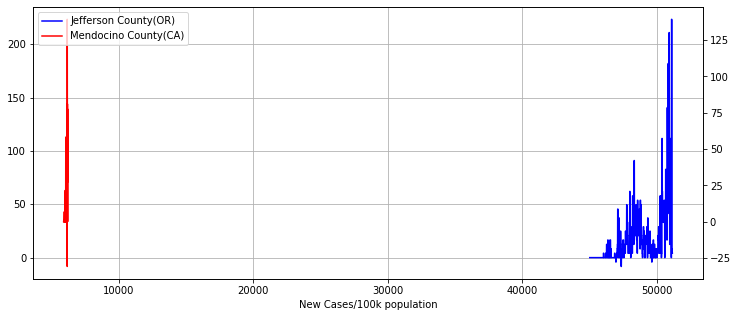

In [170]:
# TODO
plt.figure(figsize=(12,5))
plt.xlabel('New Cases/100k population')

ax1 = df_jefferson_county["New Cases/100k population"].plot(color='blue', grid=True, label='Jefferson County(OR)')
ax2 = df_Mendocino_county["New Cases/100k population"].plot(color='red', grid=True, secondary_y=True, label='Mendocino County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

##### Decisions after Observation and Analysis
* filter each county
* check how each column of demographic is varying - std.dev
* std.dev is zero -> Eg., Pop.Density
* std.dev less -> mean
* std.dev is too high -> we will use worst case like min() or max() 

* **Decisions after Observation and Analysis** :
> * std.dev is zero for these columns: [X..people.older.than.60,Median.income, X..Hispanic.Americans,Employment.density]; Hence taking the columns values as it is.
> * worst case scenerios for these columns [ 'Testing.capacity' (min),'Ventilator.shortage' (?max),'Unemployment.rate'(max),'Unemployment.claims.1000.people'(max)] -#columns that are somewhat related to pandemic
> * Removed Median Income, adding this was causing some issues, all the OR counties were mapping to Santa Clara County only

In [ ]:
or_bin_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
or_county_list = or_bin_superset_data_filtered['County Name'].unique()

In [ ]:
#for county in or_county_list:
value_list = []
value_list_with_county = []
for i in range(0, len(or_county_list)):
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  #print("county",or_county_list[i])
  #print(or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']==or_county_list[i]].describe().T)
  #print("******************************************")
  #or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']=='Jefferson County'].describe().T
  temp_df = or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']==or_county_list[i]]
  
  ################################1
  PopDensity =0
  if temp_df['PopDensity'].std() == 0.0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() < 0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() > 0: #and temp_df['PopDensity'].std() < 100:
    PopDensity = temp_df['PopDensity'].mean()
  ################################2
  X_people_older_than_60 =0
  if temp_df['X..people.older.than.60'].std() == 0.0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() < 0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  ################################3
  Median_income =0
  if temp_df['Median.income'].std() == 0.0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() < 0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Median_income = temp_df['Median.income'].mean()
  ################################4
  X_African_Americans =0
  if temp_df['X..African.Americans'].std() == 0.0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() < 0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  ################################5
  X_Hispanic_Americans =0
  if temp_df['X..Hispanic.Americans'].std() == 0.0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() < 0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  ################################6
  X_Male =0
  if temp_df['X..Male'].std() == 0.0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() < 0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Male = temp_df['X..Male'].mean()
  ################################7
  Employment_density =0
  if temp_df['Employment.density'].std() == 0.0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() < 0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Employment_density = temp_df['Employment.density'].mean()
  ####################################
  #columns that are somewhat related to pandemic
  ####################################8
  Testing_capacity =0
  if temp_df['Testing.capacity'].std() == 0.0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() < 0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 0 and temp_df['Testing.capacity'].std() < 100:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 100:
    Testing_capacity = temp_df['Testing.capacity'].min() #worst case
  ####################################9
  Ventilator_shortage =0
  if temp_df['Ventilator.shortage'].std() == 0.0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() < 0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 0 and temp_df['Ventilator.shortage'].std() < 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].max() #worst case #scs-has doubt
  ####################################10
  Unemployment_rate =0
  if temp_df['Unemployment.rate'].std() == 0.0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() < 0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 0 and temp_df['Unemployment.rate'].std() < 100:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 100:
    Unemployment_rate = temp_df['Unemployment.rate'].max() #worst case 
  ####################################11
  Unemployment_claims_1000_people =0
  if temp_df['Unemployment.claims.1000.people'].std() == 0.0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() < 0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 0 and temp_df['Unemployment.claims.1000.people'].std() < 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].max() #worst case
  ####################################
  value_list.append((PopDensity,X_people_older_than_60,#Median_income,
                     X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))
  value_list_with_county.append((*temp_df['FIPS'].unique(),or_county_list[i],PopDensity,X_people_older_than_60,Median_income,X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))

or_knn_df = pd.DataFrame(value_list, columns=('PopDensity', 'X..people.older.than.60',
       #'Median.income',  --temporary
       'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
or_knn_df_with_county = pd.DataFrame(value_list_with_county, columns=('FIPS', 'County Name','PopDensity',
                                                                      'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
print(len(or_knn_df))
f



32


In [ ]:
print(len(or_knn_df))
or_knn_df.head(2)

32


,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,5.013675,26.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,0.372079,33.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


In [ ]:
or_knn_df_with_county.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,41037.0,Lake County,0.372079,33.0,36627.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


#### Analysis: Demographic Column Mapping for CA(County wise)

In [ ]:
ca_labeled_superset_data_filtered = ca_labeled_superset_data[demographic_cols]

In [ ]:
ca_labeled_superset_data_filtered.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,6001,Alameda County,860.757075,19,92574,10.5,22.5,49.11,1155,0.0,0,5.3,1.1
1,6001,Alameda County,860.757075,19,92574,10.5,22.5,49.11,1155,0.0,0,5.3,1.1


In [ ]:
ca_labeled_superset_data_filtered['FIPS'].unique()

array([6001, 6005, 6007, 6009, 6011, 6013, 6015, 6017, 6019, 6021, 6023,
       6025, 6027, 6029, 6031, 6033, 6035, 6037, 6039, 6041, 6043, 6045,
       6047, 6051, 6053, 6055, 6057, 6059, 6061, 6063, 6065, 6067, 6069,
       6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087, 6089, 6093,
       6095, 6097, 6099, 6101, 6103, 6107, 6109, 6111, 6113, 6115])

In [ ]:
ca_labeled_superset_data_filtered['County Name'].unique()

array(['Alameda County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Mono County', 'Monterey County', 'Napa County',
       'Nevada County', 'Orange County', 'Placer County', 'Plumas County',
       'Riverside County', 'Sacramento County', 'San Benito County',
       'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Siskiyou County', 'Solano County',
       'Sonoma County', 'Stanislaus County', 'Su

In [ ]:
ca_fips_list= list(ca_labeled_superset_data_filtered['FIPS'].unique())
ca_county_list= list(ca_labeled_superset_data_filtered['County Name'].unique())
len(ca_fips_list)

54

In [ ]:
ca_labeled_superset_data_filtered[ca_labeled_superset_data_filtered['County Name']=='Solano County'].describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,292.0,6095.000000,0.000000e+00,6095.000000,6095.000000,6095.000000,6095.000000,6095.000000
PopDensity,292.0,206.044406,4.555280e-13,206.044406,206.044406,206.044406,206.044406,206.044406
X..people.older.than.60,292.0,21.000000,0.000000e+00,21.000000,21.000000,21.000000,21.000000,21.000000
Median.income,292.0,77609.000000,0.000000e+00,77609.000000,77609.000000,77609.000000,77609.000000,77609.000000
X..African.Americans,292.0,13.600000,6.227922e-14,13.600000,13.600000,13.600000,13.600000,13.600000
X..Hispanic.Americans,292.0,26.100000,1.352349e-13,26.100000,26.100000,26.100000,26.100000,26.100000
X..Male,292.0,49.700000,2.419993e-13,49.700000,49.700000,49.700000,49.700000,49.700000
Employment.density,292.0,180.000000,0.000000e+00,180.000000,180.000000,180.000000,180.000000,180.000000
Testing.capacity,292.0,7.159589,4.039574e+00,0.000000,5.300000,6.000000,6.600000,30.300000
Ventilator.shortage,292.0,632.784247,4.740710e+02,0.000000,363.250000,601.500000,685.250000,2902.000000


In [ ]:
ca_labeled_superset_data_filtered[ca_labeled_superset_data_filtered['County Name']=='Los Angeles County'].describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,292.0,6037.000000,0.000000e+00,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000
PopDensity,292.0,960.742778,5.124690e-12,960.742778,960.742778,960.742778,960.742778,960.742778
X..people.older.than.60,292.0,18.000000,0.000000e+00,18.000000,18.000000,18.000000,18.000000,18.000000
Median.income,292.0,64251.000000,0.000000e+00,64251.000000,64251.000000,64251.000000,64251.000000,64251.000000
X..African.Americans,292.0,7.900000,4.270575e-14,7.900000,7.900000,7.900000,7.900000,7.900000
X..Hispanic.Americans,292.0,48.500000,0.000000e+00,48.500000,48.500000,48.500000,48.500000,48.500000
X..Male,292.0,49.280000,2.348816e-13,49.280000,49.280000,49.280000,49.280000,49.280000
Employment.density,292.0,972.000000,0.000000e+00,972.000000,972.000000,972.000000,972.000000,972.000000
Testing.capacity,292.0,7.159589,4.039574e+00,0.000000,5.300000,6.000000,6.600000,30.300000
Ventilator.shortage,292.0,632.784247,4.740710e+02,0.000000,363.250000,601.500000,685.250000,2902.000000


##### Decisions after Observation and Analysis 

* filter each county
* check how each column of demographic is varying - std.dev
* std.dev is zero -> Eg., Pop.Density
* std.dev less -> mean
* std.dev is too high -> we will use worst case like min() or max() 

* **Decisions after Observation and Analysis** :
> * std.dev is zero for these columns: [X..people.older.than.60,Median.income, Employment.density]; Hence taking the columns values as it is.
> * worst case scenerios for these columns [ 'Testing.capacity' (min),'Ventilator.shortage' (?max),'Unemployment.rate'(max),'Unemployment.claims.1000.people'(max)] -#columns that are somewhat related to pandemic

In [ ]:
print(len(ca_labeled_superset_data_filtered))
print(len(ca_county_list))

15391
54


In [ ]:
ca_labeled_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
#for county in or_county_list:
value_list = []
value_list_with_county = []
for i in range(0, len(ca_county_list)):
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  #print("county",or_county_list[i])
  #print(or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']==or_county_list[i]].describe().T)
  #print("******************************************")
  #or_bin_superset_data_filtered[or_bin_superset_data_filtered['County Name']=='Jefferson County'].describe().T
  temp_df = ca_labeled_superset_data_filtered[ca_labeled_superset_data_filtered['County Name']==ca_county_list[i]]
  
  ################################1
  PopDensity =0
  if temp_df['PopDensity'].std() == 0.0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() < 0:
    PopDensity = temp_df['PopDensity'].mean()
  if temp_df['PopDensity'].std() > 0: #and temp_df['PopDensity'].std() < 100:
    PopDensity = temp_df['PopDensity'].mean()
  ################################2
  X_people_older_than_60 =0
  if temp_df['X..people.older.than.60'].std() == 0.0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() < 0:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  if temp_df['X..people.older.than.60'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_people_older_than_60 = temp_df['X..people.older.than.60'].mean()
  ################################3
  Median_income =0
  if temp_df['Median.income'].std() == 0.0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() < 0:
    Median_income = temp_df['Median.income'].mean()
  if temp_df['Median.income'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Median_income = temp_df['Median.income'].mean()
  ################################4
  X_African_Americans =0
  if temp_df['X..African.Americans'].std() == 0.0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() < 0:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  if temp_df['X..African.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_African_Americans = temp_df['X..African.Americans'].mean()
  ################################5
  X_Hispanic_Americans =0
  if temp_df['X..Hispanic.Americans'].std() == 0.0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() < 0:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  if temp_df['X..Hispanic.Americans'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Hispanic_Americans = temp_df['X..Hispanic.Americans'].mean()
  ################################6
  X_Male =0
  if temp_df['X..Male'].std() == 0.0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() < 0:
    X_Male = temp_df['X..Male'].mean()
  if temp_df['X..Male'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    X_Male = temp_df['X..Male'].mean()
  ################################7
  Employment_density =0
  if temp_df['Employment.density'].std() == 0.0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() < 0:
    Employment_density = temp_df['Employment.density'].mean()
  if temp_df['Employment.density'].std() > 0: # and temp_df['X..people.older.than.60'].std() < 100:
    Employment_density = temp_df['Employment.density'].mean()
  ####################################
  #columns that are somewhat related to pandemic
  ####################################8
  Testing_capacity =0
  if temp_df['Testing.capacity'].std() == 0.0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() < 0:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 0 and temp_df['Testing.capacity'].std() < 100:
    Testing_capacity = temp_df['Testing.capacity'].mean()
  if temp_df['Testing.capacity'].std() > 100:
    Testing_capacity = temp_df['Testing.capacity'].min() #worst case
  ####################################9
  Ventilator_shortage =0
  if temp_df['Ventilator.shortage'].std() == 0.0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() < 0:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 0 and temp_df['Ventilator.shortage'].std() < 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].mean()
  if temp_df['Ventilator.shortage'].std() > 100:
    Ventilator_shortage = temp_df['Ventilator.shortage'].max() #worst case #scs-has doubt
  ####################################10
  Unemployment_rate =0
  if temp_df['Unemployment.rate'].std() == 0.0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() < 0:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 0 and temp_df['Unemployment.rate'].std() < 100:
    Unemployment_rate = temp_df['Unemployment.rate'].mean()
  if temp_df['Unemployment.rate'].std() > 100:
    Unemployment_rate = temp_df['Unemployment.rate'].max() #worst case 
  ####################################11
  Unemployment_claims_1000_people =0
  if temp_df['Unemployment.claims.1000.people'].std() == 0.0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() < 0:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 0 and temp_df['Unemployment.claims.1000.people'].std() < 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].mean()
  if temp_df['Unemployment.claims.1000.people'].std() > 100:
    Unemployment_claims_1000_people = temp_df['Unemployment.claims.1000.people'].max() #worst case
  ####################################
  value_list.append((PopDensity,X_people_older_than_60,#Median_income, #temp
                     X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))
  value_list_with_county.append((*temp_df['FIPS'].unique(),ca_county_list[i],PopDensity,X_people_older_than_60,Median_income,X_African_Americans,
                     X_Hispanic_Americans,X_Male,Employment_density,Testing_capacity,
                     Ventilator_shortage,Unemployment_rate,Unemployment_claims_1000_people))

ca_knn_df = pd.DataFrame(value_list, columns=('PopDensity', 'X..people.older.than.60',
       #'Median.income', #temp
       'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
ca_knn_df_with_county = pd.DataFrame(value_list_with_county, columns=('FIPS', 'County Name','PopDensity',
                                                                      'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'))
print(len(ca_knn_df))
   

54


In [ ]:
print(len(ca_knn_df))
ca_knn_df.head(2)

54


,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,860.757075,19.0,10.5,22.5,49.11,1155.0,7.159589,2902,11.916781,6.569521
1,24.565345,35.0,2.0,13.6,53.67,20.0,7.249813,2902,11.977903,6.642322


In [ ]:
ca_knn_df_with_county.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,6001,Alameda County,860.757075,19.0,92574.0,10.5,22.5,49.11,1155.0,7.159589,2902,11.916781,6.569521
1,6005,Amador County,24.565345,35.0,61198.0,2.0,13.6,53.67,20.0,7.249813,2902,11.977903,6.642322


## KNN Similarity between CA data and OR binning reduced data



In [ ]:
or_knn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PopDensity,32.0,51.662262,133.771693,0.372079,4.279683,16.210596,30.189197,715.275377
X..people.older.than.60,32.0,27.781250,6.147301,18.000000,22.750000,27.000000,33.000000,43.000000
X..African.Americans,32.0,0.812500,0.893615,0.100000,0.400000,0.650000,0.900000,5.300000
X..Hispanic.Americans,32.0,12.690625,8.973414,3.600000,7.200000,8.800000,15.975000,35.900000
X..Male,32.0,50.189062,1.553791,48.140000,49.282500,49.770000,50.497500,54.490000
Employment.density,32.0,69.093750,212.775114,1.000000,4.750000,15.500000,32.500000,1180.000000
Testing.capacity,32.0,4.710317,0.005869,4.680972,4.710101,4.712214,4.712288,4.713958
Ventilator.shortage,32.0,25.941529,0.780461,24.482247,25.535041,25.535041,27.081916,27.112772
Unemployment.rate,32.0,9.103513,0.010253,9.092390,9.097795,9.103073,9.103073,9.144470
Unemployment.claims.1000.people,32.0,3.831208,0.035659,3.817726,3.817726,3.818467,3.830935,3.972266


In [ ]:
ca_knn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PopDensity,54.0,293.333729,997.056229,0.685856,16.555064,44.159342,168.092580,7168.190471
X..people.older.than.60,54.0,22.870370,6.297787,14.000000,18.000000,21.000000,26.000000,38.000000
X..African.Americans,54.0,3.125926,2.957956,0.300000,1.225000,2.000000,4.150000,13.600000
X..Hispanic.Americans,54.0,31.792593,17.835346,8.700000,16.675000,26.300000,45.475000,83.800000
X..Male,54.0,50.463704,2.532699,48.180000,49.472500,49.845000,50.782500,66.290000
Employment.density,54.0,228.148148,514.543300,2.000000,17.250000,34.500000,138.500000,3076.000000
Testing.capacity,54.0,7.155867,0.154608,6.135648,7.159589,7.159589,7.164811,7.518721
Ventilator.shortage,54.0,2902.000000,0.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000
Unemployment.rate,54.0,11.929950,0.035432,11.901606,11.916781,11.916781,11.923770,12.138813
Unemployment.claims.1000.people,54.0,6.553722,0.187368,5.315741,6.569521,6.569521,6.572984,6.869863


In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return cosine_similarities,simiarity_ids

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
#%%time
#cosine_similarities,simiarity_ids = get_computed_similarities(vectors=ca_labeled_superset_data_filtered.values, predicted_vectors=or_bin_superset_data_filtered.values)

CPU times: user 28min 54s, sys: 1.07 s, total: 28min 55s
Wall time: 28min 54s


In [ ]:
or_knn_df.head(2)

,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,5.013675,26.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,0.372079,33.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


In [ ]:
ca_knn_df.head(2)

,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,860.757075,19.0,10.5,22.5,49.11,1155.0,7.159589,2902,11.916781,6.569521
1,24.565345,35.0,2.0,13.6,53.67,20.0,7.249813,2902,11.977903,6.642322


In [ ]:
%%time
cosine_similarities,simiarity_ids = get_computed_similarities(vectors=ca_knn_df.values, predicted_vectors=or_knn_df.values)

CPU times: user 272 ms, sys: 1.05 ms, total: 273 ms
Wall time: 273 ms


In [ ]:
cosine_similarities

[(34, array([[0.42579933]])),
 (16, array([[0.37829969]])),
 (27, array([[0.52701718]])),
 (35, array([[0.75970663]])),
 (27, array([[0.61803678]])),
 (35, array([[0.84512268]])),
 (35, array([[0.69088325]])),
 (38, array([[0.4580295]])),
 (35, array([[0.857969]])),
 (17, array([[0.43543061]])),
 (16, array([[0.37751932]])),
 (35, array([[0.56876201]])),
 (27, array([[0.55429547]])),
 (16, array([[0.42011824]])),
 (35, array([[0.82248381]])),
 (27, array([[0.56755483]])),
 (27, array([[0.49253409]])),
 (41, array([[0.42989019]])),
 (0, array([[0.429146]])),
 (27, array([[0.58907003]])),
 (27, array([[0.61365778]])),
 (27, array([[0.51641255]])),
 (34, array([[0.42164594]])),
 (27, array([[0.63830597]])),
 (11, array([[0.38124872]])),
 (11, array([[0.40476451]])),
 (35, array([[0.76849521]])),
 (16, array([[0.41168013]])),
 (17, array([[0.45190403]])),
 (17, array([[0.43253927]])),
 (40, array([[0.42416991]])),
 (35, array([[0.77239699]]))]

In [ ]:
or_knn_df_with_county['FIPS'].unique()

array([41031., 41037., 41041., 41003., 41029., 41047., 41053., 41061.,
       41067., 41019., 41023., 41009., 41043., 41001., 41005., 41007.,
       41011., 41013., 41015., 41017., 41027., 41033., 41035., 41039.,
       41045., 41049., 41051., 41055., 41057., 41059., 41065., 41071.])

In [ ]:
or_knn_df_with_county['similiary_score'] = cosine_similarities

In [ ]:
#print("CA row number=",or_bin_superset_data.iloc[0]['similiary_score'][0])
fips = []
county = []
for id in simiarity_ids:
  county_name = ca_knn_df_with_county.iloc[id]['County Name']
  county.append(county_name)
  fips_id = ca_knn_df_with_county.iloc[id]['FIPS']
  fips.append(fips_id)

print('length: ',len(county))
or_knn_df_with_county['CA_Fips']= fips
or_knn_df_with_county['CA_CountyName']= county
or_knn_df_with_county.head(2)

length:  32


,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people,similiary_score,CA_Fips,CA_CountyName
0,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935,"(34, [[0.42579932577498014]])",6073,San Diego County
1,41037.0,Lake County,0.372079,33.0,36627.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321,"(16, [[0.37829968952204324]])",6035,Lassen County


In [ ]:
or_knn_df_with_county.tail()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people,similiary_score,CA_Fips,CA_CountyName
27,41055.0,Sherman County,0.752408,32.0,48056.0,0.6,3.6,54.27,1.0,4.713958,27.112772,9.092390,3.836221,"(16, [[0.4116801262172719]])",6035,Lassen County
28,41057.0,Tillamook County,9.133057,34.0,47500.0,0.4,10.3,50.39,10.0,4.710101,27.081916,9.096906,3.830935,"(17, [[0.45190403363166703]])",6037,Los Angeles County
29,41059.0,Umatilla County,9.233698,21.0,51887.0,0.9,26.4,52.16,9.0,4.712288,25.535041,9.103073,3.817726,"(17, [[0.43253927374603873]])",6037,Los Angeles County
30,41065.0,Wasco County,4.194184,27.0,50973.0,0.3,17.8,49.94,6.0,4.711886,25.917987,9.101692,3.819863,"(40, [[0.42416991354559647]])",6085,Santa Clara County
31,41071.0,Yamhill County,55.992733,23.0,59484.0,0.8,15.8,49.98,42.0,4.712288,25.535041,9.103073,3.817726,"(35, [[0.7723969932912603]])",6075,San Francisco County


In [ ]:
#or_knn_df_with_county

In [ ]:
#or_bin_superset_data['similiary_score'] = cosine_similarities


### Save Temp File to CSV [For Analysis]

In [ ]:

from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_SuperData_With_Demographic_SimilarityScore_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_knn_df_with_county.to_csv(location+filename,index=False)

OR_SuperData_With_Demographic_SimilarityScore_Mar08.csv


In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

OR_labeled = pd.read_csv(location+'OR_SuperData_With_Demographic_SimilarityScore_Mar08.csv',low_memory=False)
OR_labeled.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
0,2020-02-29,Oregon,41031.0,0.0,Jefferson County,0.0,9.719966,92.366460,12.571429,8.857143,0.0,2.785714,0.285714,-0.928571,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,20.571429,20.071429,3.756429,30.65000,1.528571,40.892857,0.534286,3.220714,0.0,24192.0,10.514286,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.002143,43.5,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.0,0.433903,0.0,nochange,"(13649, array([[0.85638928]]))"
1,2020-03-15,Oregon,41031.0,0.0,Jefferson County,0.0,4.678473,39.923913,-23.750000,4.187500,0.0,-6.500000,-27.750000,0.000000,5.013675,Oregon,OR,41031.0,Jefferson County,41.0,32.812500,25.000000,3.389375,27.61875,1.418750,34.625000,0.463750,2.923750,0.0,24192.0,0.325000,1.08,26.0,50339.0,0.9,20.0,51.89,4.0,102.0,2.2,0.2,0.024,0.0,0.055000,58.5,49.306294,5.418750,1.125000,1.244375,9.562500,0.8125,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.0,0.000000,0.0,nochange,"(13649, array([[0.85638927]]))"


In [ ]:
df_washington_county = OR_labeled[OR_labeled['County Name'] == 'Washington County']
df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, array([[0.94165225]]))"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, array([[0.94165225]]))"


In [ ]:

ca_labeled_superset_data.filter(like = '12490', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12490,2020-03-10,California,6095,3,Solano County,0.0,7.261,101,3.0,6.0,31.0,-1.0,2.0,0.0,206.044406,California,CA,6095,Solano County,6,14,18,3.65,28.2,0.2,45.8,0.66,2.98,3,446610,0.3,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0022,0.0,0,54.028798,16.2,0.02,0.06,5,1,0.08,0,1.5,5.3,9.4,0.6,0.07,0.671727,0.011,0.095961,0.095961,nochange


In [ ]:
# use only demographic+ Pandemic behaviour related data(observed and latent variables) 
# and find the similar county in OR

## Rest of the worked will be revisited and removed mostly

## Notes for documentation
* use only demographic+ Pandemic behaviour related data(observed and latent variables) and find the similar county in OR
* Bayesian network to predict "What is the likelihood the related county will also spike?"

* Prob. of given the characteristics -> spike in cases
growth in cases / likelihood 

GNN - each county is represented as graph. each feature is a node and connected by a branch. Graph similarity 
Bayes rule - Professor share the resources 


In [ ]:
ws_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread']
print(ws_data['County Name'].nunique())
ws_data['County Name'].unique()

In [ ]:
minimal_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal']
print(minimal_data['County Name'].nunique())
minimal_data['County Name'].unique()

In [ ]:
nochange_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange']
print(nochange_data['County Name'].nunique())
nochange_data['County Name'].unique()

In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, [[0.9416522507452699]])"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, [[0.9416522460537996]])"


In [ ]:
df_washington_county = OR_labeled[OR_labeled['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
159,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, array([[0.94165225]]))"
160,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, array([[0.94165225]]))"


### Visualization

In [ ]:
df_solano_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Solano County']
print(df_solano_county.shape)
df_solano_county.head(2)

(292, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12481,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
12482,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


In [ ]:
df_solano_county.index = pd.to_datetime(df_solano_county["Date"])

df_solano_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
2020-03-02,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


### Merging Solano and Washington county

In [ ]:
df_washington_county.index = pd.to_datetime(df_washington_county["Date"])

df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41067.0,0.853846,Washington County,0.0,9.536064,94.343590,1.782051,2.456410,27.805128,-3.200000,-1.525641,1.258974,310.164459,Oregon,OR,41067.0,Washington County,41.0,22.943590,21.548718,3.536538,28.142564,2.236667,33.662564,0.565564,2.968846,0.853846,597695.0,-0.219487,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001275,0.002103,0.000000,48.812293,5.981538,0.035436,0.024923,0.207692,1.202564,0.061359,0.00000,1.000000,3.30000,7.247692,0.6,0.000000,0.142856,0.304167,0.003598,nochange,"(13649, array([[0.94165225]]))"
2020-03-15,2020-03-15,Oregon,41067.0,9.731982,Washington County,0.0,4.223745,41.497748,-37.288288,-12.495495,30.878378,-43.211712,-42.806306,16.842342,310.164459,Oregon,OR,41067.0,Washington County,41.0,53.364865,35.430180,2.848063,24.745495,2.106306,22.321396,0.400676,2.447410,9.731982,597695.0,-17.762162,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.015051,0.055293,0.184685,49.307290,5.414865,1.131869,1.247523,9.585586,15.752252,0.046261,3.09009,8.496396,6.66036,23.181081,0.6,3.694572,1.628252,1.615817,0.001330,nochange,"(13649, array([[0.94165225]]))"


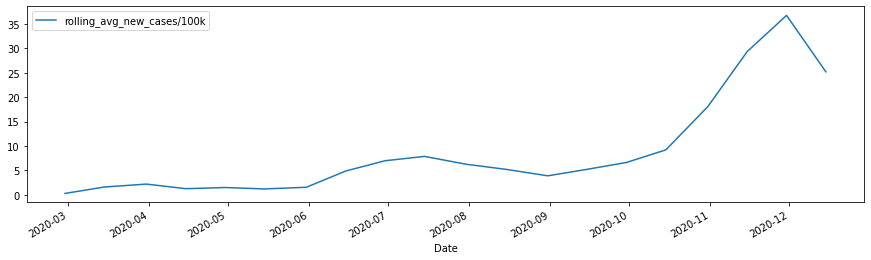

In [ ]:
df_washington_county[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


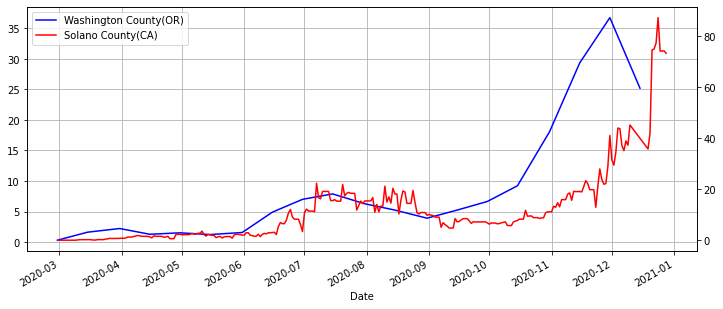

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df_washington_county["rolling_avg_new_cases/100k"].plot(color='blue', grid=True, label='Washington County(OR)')
ax2 = df_solano_county["rolling_avg_new_cases/100k"].plot(color='red', grid=True, secondary_y=True, label='Solano County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
df_washington_county_minimal = df_washington_county[df_washington_county['growth_label'] == 'minimal']
df_washington_county_nc = df_washington_county[df_washington_county['growth_label'] == 'nochange']
df_washington_county_widespread = df_washington_county[df_washington_county['growth_label'] == 'widespread']

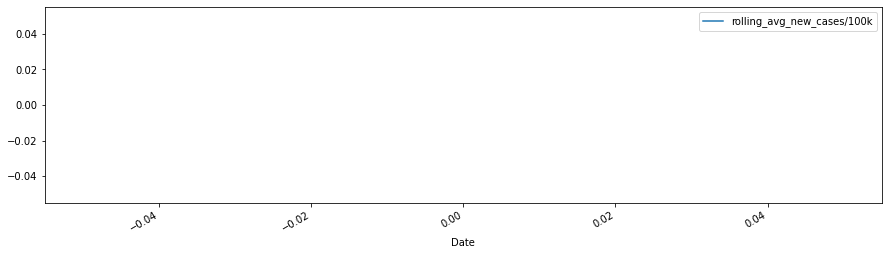

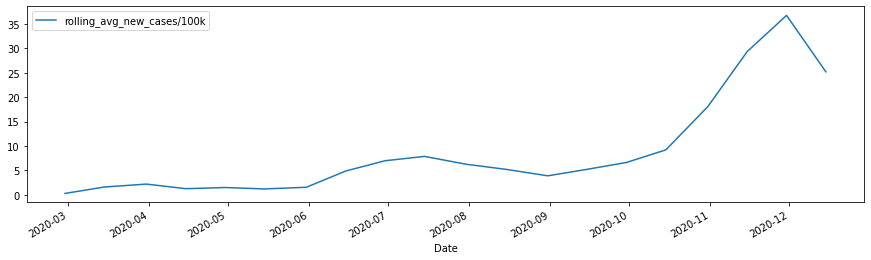

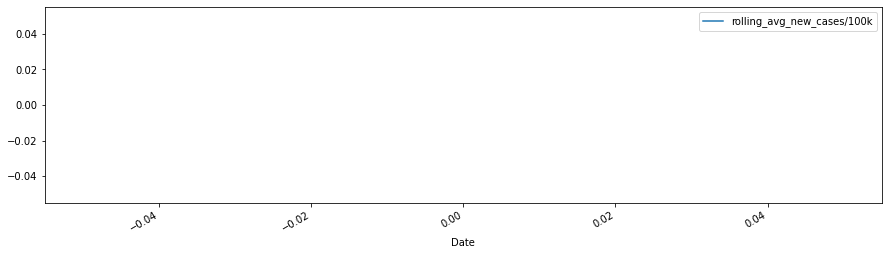

In [ ]:
#df_washington_county.plot(figsize=(15,4))
#df_washington_county.plot(subplots=True, figsize=(15,6))
#df_washington_county_minimal.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
#df_washington_county_nc.plot(y=["rolling_avg_new_cases/100k"], figsize=(15,4))
df_washington_county_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_washington_county_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_washington_county_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))


#df.plot(x="R", y=["F10.7", "Dst"], style='.')

In [ ]:
df_Multnomah_County = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Multnomah County']
df_Multnomah_County.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
518,2020-02-29,Oregon,41051.0,0.071429,Multnomah County,0.0,4.281643,84.857143,2.071429,7.285714,25.500000,-2.500000,-1.285714,0.928571,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,23.714286,24.214286,3.540000,32.857143,10.842857,35.478571,0.495000,3.042143,0.071429,811880.0,0.814286,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.000086,0.002143,29.642857,48.812683,5.992857,0.035714,0.025714,0.214286,4.357143,0.061429,0.000000,1.000000,3.300000,7.250000,0.600000,0.000000,0.008798,0.008798,0.000240,nochange,"(13649, [[0.9102240408728535]])"
519,2020-03-15,Oregon,41051.0,6.187500,Multnomah County,0.0,0.792187,15.250000,-46.625000,-10.687500,12.375000,-46.062500,-41.937500,15.812500,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,52.500000,38.000000,2.869375,29.387500,9.493750,25.856250,0.365625,2.504375,6.187500,811880.0,-16.981250,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.006900,0.055000,0.000000,49.306294,5.418750,1.125000,1.244375,9.562500,43.687500,0.046250,3.062500,8.468750,6.643750,23.131250,0.600000,3.675000,0.762120,0.481686,0.000613,nochange,"(13649, [[0.910224033966212]])"
520,2020-03-31,Oregon,41051.0,21.333333,Multnomah County,0.0,0.171800,2.933333,-54.066667,-16.333333,12.800000,-56.533333,-53.133333,19.466667,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,59.933333,40.400000,2.764000,28.226667,8.866667,18.960000,0.322667,2.442667,21.333333,811880.0,-19.033333,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.025180,0.264000,0.066667,50.132514,5.160000,5.416667,5.640667,25.933333,173.266667,0.060667,18.200000,11.873333,13.086667,26.306667,0.226667,12.996000,2.627646,2.262826,0.000465,nochange,"(13664, [[0.9102240509430546]])"
521,2020-04-15,Oregon,41051.0,19.285714,Multnomah County,0.0,0.204000,3.357143,-50.285714,-14.714286,11.571429,-55.000000,-51.071429,18.071429,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,55.928571,38.285714,2.786429,29.714286,9.521429,23.035714,0.295714,2.490714,19.285714,811880.0,-17.457143,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.023229,0.420714,2.500000,50.062779,4.814286,10.334286,8.497143,25.785714,266.642857,0.092857,33.500000,10.242857,14.614286,28.185714,0.200000,20.927857,2.375439,2.610469,0.000225,nochange,"(13664, [[0.9102240502819475]])"
522,2020-04-30,Oregon,41051.0,16.266667,Multnomah County,0.0,0.355133,6.666667,-45.466667,-8.733333,19.866667,-51.666667,-48.466667,16.733333,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,50.000000,34.733333,2.952000,30.540000,9.906667,24.880000,0.296000,2.653333,16.266667,811880.0,-12.060000,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.020040,0.422000,3.600

In [ ]:
df_Multnomah_County.index = pd.to_datetime(df_Multnomah_County["Date"])

df_Multnomah_County.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate,growth_label,similiary_score
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41051.0,0.071429,Multnomah County,0.0,4.281643,84.857143,2.071429,7.285714,25.500,-2.5000,-1.285714,0.928571,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,23.714286,24.214286,3.540000,32.857143,10.842857,35.478571,0.495000,3.042143,0.071429,811880.0,0.814286,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.000086,0.002143,29.642857,48.812683,5.992857,0.035714,0.025714,0.214286,4.357143,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.008798,0.008798,0.000240,nochange,"(13649, [[0.9102240408728535]])"
2020-03-15,2020-03-15,Oregon,41051.0,6.187500,Multnomah County,0.0,0.792187,15.250000,-46.625000,-10.687500,12.375,-46.0625,-41.937500,15.812500,715.275377,Oregon,OR,41051.0,Multnomah County,41.0,52.500000,38.000000,2.869375,29.387500,9.493750,25.856250,0.365625,2.504375,6.187500,811880.0,-16.981250,11.61,18.0,64337.0,5.3,11.4,49.54,1180.0,185.0,2.2,0.2,0.024,0.006900,0.055000,0.000000,49.306294,5.418750,1.125000,1.244375,9.562500,43.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.762120,0.481686,0.000613,nochange,"(13649, [[0.910224033966212]])"


In [ ]:
df_Multnomah_County_minimal = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'minimal']
df_Multnomah_County_nc = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'nochange']
df_Multnomah_County_widespread = df_Multnomah_County[df_Multnomah_County['growth_label'] == 'widespread']

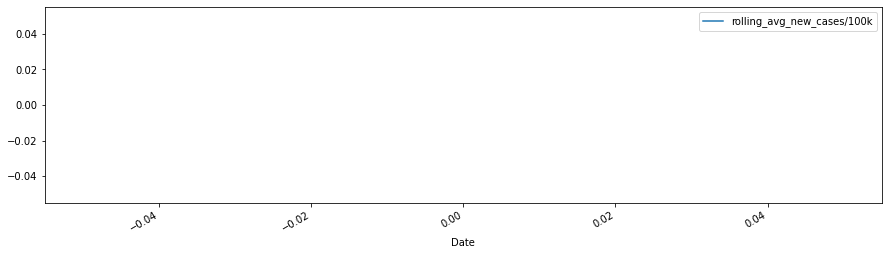

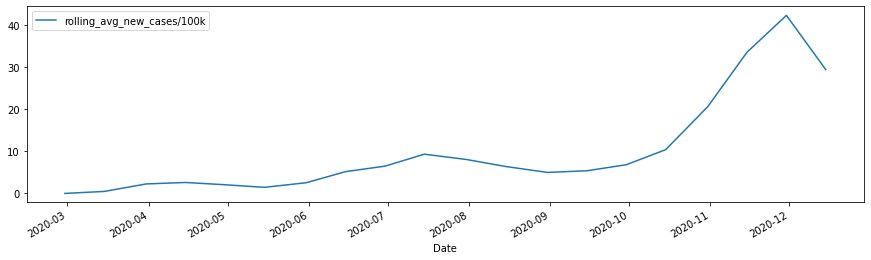

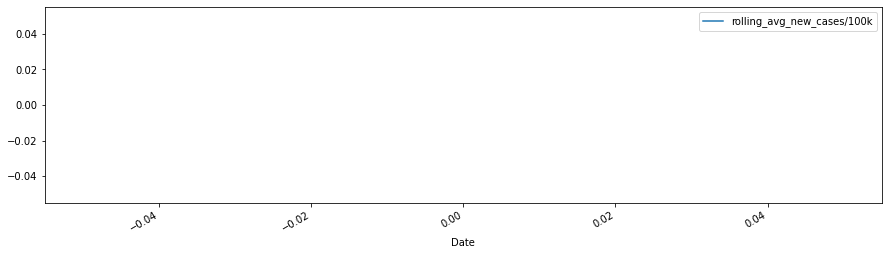

In [ ]:
df_Multnomah_County_minimal[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))
df_Multnomah_County_nc[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

df_Multnomah_County_widespread[["rolling_avg_new_cases/100k", "growth_label"]].plot(figsize=(15,4))

# Conclusion, Details, and Observation-OLD

* I have fixed the and changed the logic of cosine similarity code
* There are two options, I have followed to compute the similarity score for Oregon

> 1. **Option1:** A= Oregon , B= CA ; Outer loop= OR, Inner Loop= CA
>> * I have taken Oregon data and all the labeled CA data
>> * Then I have compared each row of Oregon with all the rows of CA labeled data. I cann't filter here the 'superspread' CA labeled data, because then OR data will be forcefully tagged as 'superspread'.
>> * I have stored the similarity score and the CA dataframe's row number pair in Oregon dataframe. 
>> * So now each row of Oregon dataset has the similarity score with the matching row number of CA dataframe.

> **2. Option2:** A= CA-Superspread B= Oregon ,  ; Outer loop= CA-Superspread, Inner Loop= OR
>> * This is opposite of option-1 and I think this the is the best way.
>> * Here I have filtered the 'superspread' data of CA labeled data
>> * Then I have compared the 'superspread' CA data with each rows of Oregon data to compute the cosine similarity
>> * Final output, for each row in 'superspread' CA data, I am storing the matching/ high similarity row number from Oregon dataset.
>> * Here we have to analize less number of data and only the superspread data
>> * I have analized few rows and found 'Washington County' of Oregon as a superspread county and high similarity with CA superspread data. This is matching with current situation also.